<a href="https://colab.research.google.com/github/natdosan/cogs138project/blob/main/final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction & Background

https://mkhosla-ucsd.github.io/cogs138/final-group-project/part-one

### Overview

 ❏    Write a clear summary of what you did

 ❏    Limit overview to 3-4 sentences


### Research Question
 ❏    Include your _specific_ data science question

 ❏    Make sure what you’re measuring (variables) to answer your question is clear


### Background & Prior Work
 ❏    Include explanation of what work has been done previously

 ❏    Include citations or links to previous work

 ❏    Include an explanation of dataset(s) used (_i.e._, how the data was collected, features/variables included, number of observations, information in dataset)


### Hypothesis
 ❏    Include your team’s hypothesis

 ❏    Ensure that this hypothesis is clear to readers

 ❏    Explain why you think this will be the outcome (what was your thinking?)


# Data Analysis

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
import scipy
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report, confusion_matrix


import PIL
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import glob
import warnings
import os
from util import *

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Wrangling
 ❏    Pull your data into Python and explain steps taken to isolate the data you need

Nate created a dataloader function so that we can load in all the data into separate arrays as well as see the number of examples in each to help assess any class imbalances. As seen below, all images are of 128 x 128 pixels, and there are two classes which make up the majority of the examples, non demented and very mildly demented patients. This result is not too surprising as we would expect a majority of patients to not have mild / moderate demensia.

In [4]:
non_demented = dataloader('/content/drive/MyDrive/Colab/final_project/data/Non_Demented')
very_mild_demented = dataloader('/content/drive/MyDrive/Colab/final_project/data/Very_Mild_Demented')
mild_demented = dataloader('/content/drive/MyDrive/Colab/final_project/data/Mild_Demented')
moderate_demented = dataloader('/content/drive/MyDrive/Colab/final_project/data/Moderate_Demented')

Loaded 3200 images with shape (128, 128)
Loaded 2240 images with shape (128, 128)
Loaded 896 images with shape (128, 128)
Loaded 64 images with shape (128, 128)


Epoch 1/10
160/160 [==============================] - 4s 19ms/step - loss: 0.6740 - accuracy: 0.5654 - val_loss: 0.6187 - val_accuracy: 0.6703
Epoch 2/10
160/160 [==============================] - 3s 16ms/step - loss: 0.5919 - accuracy: 0.7000 - val_loss: 0.5536 - val_accuracy: 0.7125
Epoch 3/10
160/160 [==============================] - 3s 16ms/step - loss: 0.5415 - accuracy: 0.7361 - val_loss: 0.5146 - val_accuracy: 0.7445
Epoch 4/10
160/160 [==============================] - 3s 16ms/step - loss: 0.4723 - accuracy: 0.7719 - val_loss: 0.4433 - val_accuracy: 0.7570
Epoch 5/10
160/160 [==============================] - 3s 16ms/step - loss: 0.4021 - accuracy: 0.8111 - val_loss: 0.3584 - val_accuracy: 0.8273
Epoch 6/10
160/160 [==============================] - 3s 16ms/step - loss: 0.3277 - accuracy: 0.8492 - val_loss: 0.2917 - val_accuracy: 0.8609
Epoch 7/10
160/160 [==============================] - 3s 16ms/step - loss: 0.2370 - accuracy: 0.8963 - val_loss: 0.2736 - val_accuracy: 0.8852

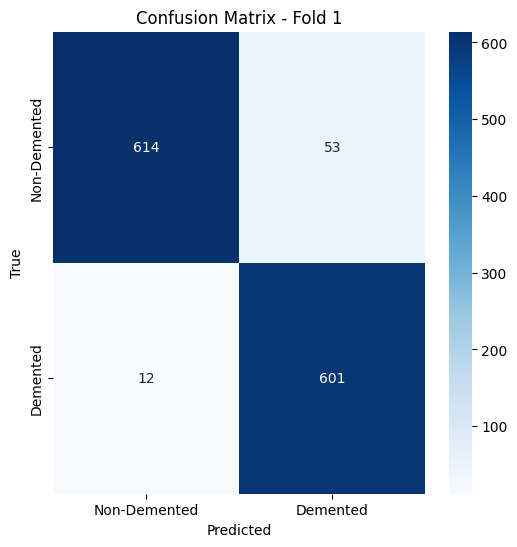

Epoch 1/10
160/160 [==============================] - 4s 19ms/step - loss: 0.6456 - accuracy: 0.6303 - val_loss: 0.5589 - val_accuracy: 0.7398
Epoch 2/10
160/160 [==============================] - 3s 16ms/step - loss: 0.5669 - accuracy: 0.7250 - val_loss: 0.5224 - val_accuracy: 0.7578
Epoch 3/10
160/160 [==============================] - 3s 16ms/step - loss: 0.4885 - accuracy: 0.7635 - val_loss: 0.4188 - val_accuracy: 0.8070
Epoch 4/10
160/160 [==============================] - 3s 16ms/step - loss: 0.3986 - accuracy: 0.8129 - val_loss: 0.3474 - val_accuracy: 0.8453
Epoch 5/10
160/160 [==============================] - 3s 16ms/step - loss: 0.2857 - accuracy: 0.8785 - val_loss: 0.2331 - val_accuracy: 0.9055
Epoch 6/10
160/160 [==============================] - 3s 16ms/step - loss: 0.1859 - accuracy: 0.9283 - val_loss: 0.1874 - val_accuracy: 0.9258
Epoch 7/10
160/160 [==============================] - 3s 16ms/step - loss: 0.1254 - accuracy: 0.9514 - val_loss: 0.1187 - val_accuracy: 0.9547

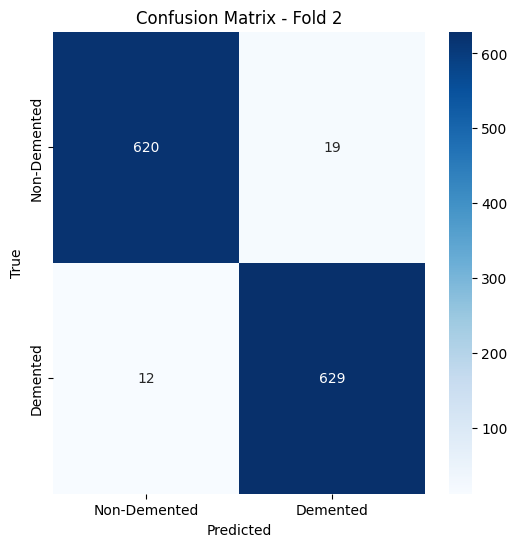

Epoch 1/10
160/160 [==============================] - 5s 19ms/step - loss: 0.6635 - accuracy: 0.5902 - val_loss: 0.6222 - val_accuracy: 0.6570
Epoch 2/10
160/160 [==============================] - 3s 17ms/step - loss: 0.5869 - accuracy: 0.7039 - val_loss: 0.5548 - val_accuracy: 0.7242
Epoch 3/10
160/160 [==============================] - 3s 16ms/step - loss: 0.5503 - accuracy: 0.7303 - val_loss: 0.5282 - val_accuracy: 0.7391
Epoch 4/10
160/160 [==============================] - 3s 16ms/step - loss: 0.4803 - accuracy: 0.7637 - val_loss: 0.5082 - val_accuracy: 0.7484
Epoch 5/10
160/160 [==============================] - 3s 16ms/step - loss: 0.4257 - accuracy: 0.7914 - val_loss: 0.4074 - val_accuracy: 0.8008
Epoch 6/10
160/160 [==============================] - 3s 16ms/step - loss: 0.3494 - accuracy: 0.8486 - val_loss: 0.3874 - val_accuracy: 0.8102
Epoch 7/10
160/160 [==============================] - 3s 16ms/step - loss: 0.2739 - accuracy: 0.8795 - val_loss: 0.2674 - val_accuracy: 0.8875

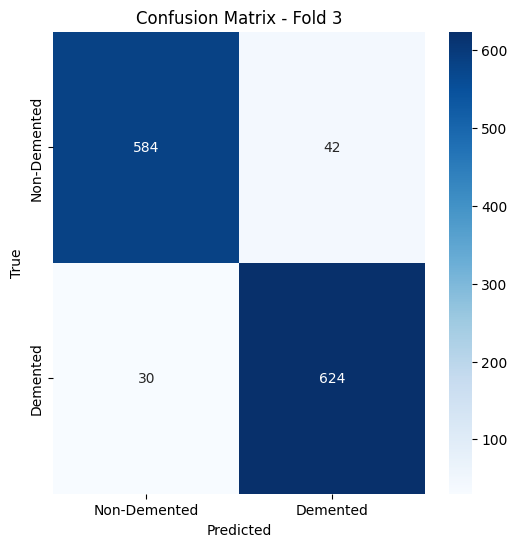

Epoch 1/10
160/160 [==============================] - 4s 19ms/step - loss: 0.6520 - accuracy: 0.6053 - val_loss: 0.5900 - val_accuracy: 0.6953
Epoch 2/10
160/160 [==============================] - 3s 16ms/step - loss: 0.5620 - accuracy: 0.7135 - val_loss: 0.5492 - val_accuracy: 0.7023
Epoch 3/10
160/160 [==============================] - 3s 16ms/step - loss: 0.4724 - accuracy: 0.7732 - val_loss: 0.4457 - val_accuracy: 0.7750
Epoch 4/10
160/160 [==============================] - 3s 16ms/step - loss: 0.3753 - accuracy: 0.8240 - val_loss: 0.3579 - val_accuracy: 0.8203
Epoch 5/10
160/160 [==============================] - 3s 16ms/step - loss: 0.2929 - accuracy: 0.8699 - val_loss: 0.2973 - val_accuracy: 0.8602
Epoch 6/10
160/160 [==============================] - 3s 16ms/step - loss: 0.1998 - accuracy: 0.9170 - val_loss: 0.2546 - val_accuracy: 0.9102
Epoch 7/10
160/160 [==============================] - 3s 16ms/step - loss: 0.1376 - accuracy: 0.9467 - val_loss: 0.1638 - val_accuracy: 0.9414

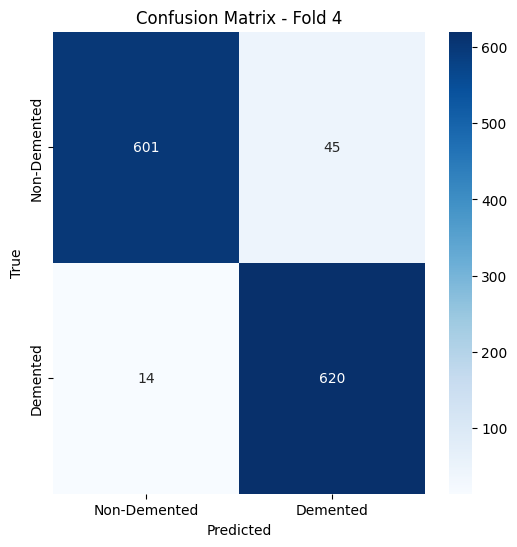

Epoch 1/10
160/160 [==============================] - 5s 19ms/step - loss: 0.6735 - accuracy: 0.5789 - val_loss: 0.6188 - val_accuracy: 0.6602
Epoch 2/10
160/160 [==============================] - 3s 16ms/step - loss: 0.5876 - accuracy: 0.6945 - val_loss: 0.5322 - val_accuracy: 0.7398
Epoch 3/10
160/160 [==============================] - 3s 16ms/step - loss: 0.5412 - accuracy: 0.7283 - val_loss: 0.5350 - val_accuracy: 0.7172
Epoch 4/10
160/160 [==============================] - 3s 16ms/step - loss: 0.4840 - accuracy: 0.7623 - val_loss: 0.4199 - val_accuracy: 0.7961
Epoch 5/10
160/160 [==============================] - 3s 16ms/step - loss: 0.4008 - accuracy: 0.8156 - val_loss: 0.3985 - val_accuracy: 0.8008
Epoch 6/10
160/160 [==============================] - 3s 16ms/step - loss: 0.3189 - accuracy: 0.8631 - val_loss: 0.2831 - val_accuracy: 0.8797
Epoch 7/10
160/160 [==============================] - 3s 16ms/step - loss: 0.2273 - accuracy: 0.9100 - val_loss: 0.2262 - val_accuracy: 0.9039

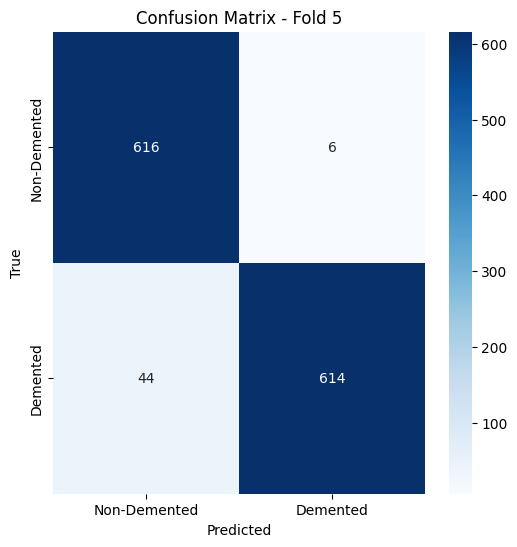

Average Cross-Validation Accuracy: 95.67%


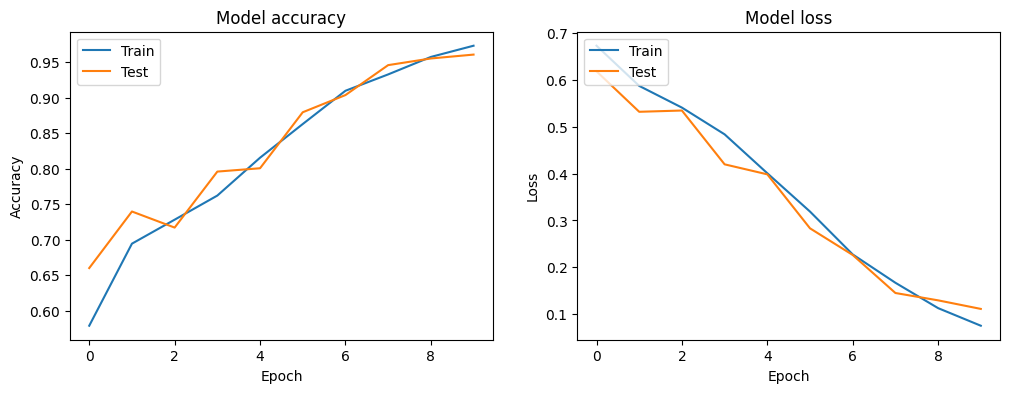

In [13]:
non_demented_labels = np.zeros(non_demented.shape[0])
demented_labels = np.ones(very_mild_demented.shape[0] + mild_demented.shape[0] + moderate_demented.shape[0])


X = np.concatenate((non_demented, very_mild_demented, mild_demented, moderate_demented), axis=0)
y = np.concatenate((non_demented_labels, demented_labels), axis=0)

if len(X.shape) == 3:
    X = np.expand_dims(X, axis=-1)


X = X / 255.0


kf = KFold(n_splits=5, shuffle=True, random_state=42)


cv_results = []

for i, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]


    y_train = to_categorical(y_train, num_classes=2)
    y_test = to_categorical(y_test, num_classes=2)


    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3])),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(2, activation='softmax')
    ])


    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))


    loss, accuracy = model.evaluate(X_test, y_test)
    print(f'Test Accuracy: {accuracy * 100:.2f}%')


    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)
    print(classification_report(y_true, y_pred_classes))
    print(confusion_matrix(y_true, y_pred_classes))

    cm = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Demented', 'Demented'], yticklabels=['Non-Demented', 'Demented'])
    plt.title(f'Confusion Matrix - Fold {i+1}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    cv_results.append(accuracy)


average_accuracy = np.mean(cv_results)
print(f'Average Cross-Validation Accuracy: {average_accuracy * 100:.2f}%')


plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

### Visualization
 ❏    Include at least three visualizations

 ❏    Clearly label all axes on plots

 ❏    Type of all plots appropriate given data displayed

 ❏    Interpretation of each visualization included in text


### Results
 ❏    Appropriate analysis performed

 ❏    Output of analysis interpreted and interpretation included in notebook


# Conclusion & Discussion
❏    Discussion of your results and how they address your experimental question

❏    Limitations of analysis discussed

❏    What additional experiments would be interesting, and what data would you need?